###**Import Libraries**

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###**Fitness Function**

1. Determine the optimal weights w1, w2, and w3 to minimize the risk score across all nodes for:
𝑹𝒊𝒔𝒌 𝑺𝒄𝒐𝒓𝒆 = 𝒘𝟏 × 𝑹𝒂𝒕𝒆_𝒐𝒇_𝑬𝒏𝒆𝒓𝒈𝒚_𝑪𝒐𝒏𝒔𝒖𝒎𝒑𝒕𝒊𝒐𝒏 + 𝒘𝟐 × 𝑻𝑻𝑳 + 𝒘𝟑 × 𝑯𝒐𝒑_𝑪𝒐𝒖𝒏𝒕
Constraints:
1. Each weight w1, w2, w3 must be a value between 0 and 1.
2. w1+w2+w3=1
3. The risk score for any node should not exceed 100.
4. The total network risk score should not be less than 50.

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('WSNBFSFdataset V2.csv')
df.head(1)

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,...,Broadcast_ID,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,behaviour,Type,rate_of_energy_consumption,cumulative_energy_consumption,energy_consumption
0,1,0.1,79,79,600.0,5,0,79.255,1.255,48,...,1,100,0,79,4,No attack,normal,0.0,0.0,0.0


In [3]:
def fitness_function(ind):  
    TTL = df['TTL']
    Hop_Count = df['Hop_Count']
    rate_of_energy_consumption = df['rate_of_energy_consumption']
    w1, w2, w3 = ind
    
    # Check if weights sum up to more than 1.0
    if w1 + w2 + w3 > 1.0:
        return 9999999
    
    # Check if any weight is less than 0.1
    if w1 < 0.1 or w2 < 0.1 or w3 < 0.1:
        return 9999999
    
    # Calculate risk scores based on weights
    df['risk_score'] = w1 * rate_of_energy_consumption + w2 * TTL + w3 * Hop_Count
    
    # Check if any risk score is above 100
    if any(df['risk_score'] > 100):
        return 9999999
    
    # Calculate the total network risk
    total_network_risk = df['risk_score'].sum()
    
    # Check if total network risk is below 50
    if total_network_risk < 50:
        return 9999999
    
    # Return the minimum risk score as the fitness value
    return df['risk_score'].min()



###**Genetic Algorithm**

In [4]:
#Creates a random individual
def individual(ind_size, ind_limits):
    ind = []
    for i in range(ind_size):
        ind.append(random.uniform(ind_limits[i][0], ind_limits[i][1]))
    return ind

In [5]:
#Performs crossover between two parents
def crossover(parent1, parent2):
    if len(parent1) == 1:
        return parent1  # Or you could do some other type of mixing, but with 1 element it's a moot point
    point = random.randint(1, len(parent1) - 1)
    child = parent1[:point] + parent2[point:]
    return child

In [6]:
#Mutates the child
def mutate(child, ind_limits):
    index = random.randint(0, len(child) - 1)
    child[index] = random.uniform(ind_limits[index][0], ind_limits[index][1])
    return child

In [7]:
#Select two parents based on fitness
def select_parents(population, fit_func):
    k = 2
    parent1 = population[0]
    parent2 = max(random.choices(population, k=k), key=fit_func)
    return parent1, parent2

In [8]:


def genetic_algorithm(ind_size, ind_limits, fit_func, pop_size, gen_max):
    population = []
    best_fitnesses = []  # This list will store the best fitness in each generation
    for i in range(pop_size):
        population.append(individual(ind_size, ind_limits))
    for gen in range(gen_max):
        population.sort(key=fit_func)
        best_fitness = fit_func(population[0])  # Take the best individual's fitness
        best_fitnesses.append(best_fitness)  # Add the best fitness to the list
        parent1, parent2 = select_parents(population, fit_func)

        child = crossover(parent1, parent2)
        child = mutate(child, ind_limits)

        # Replace the least fit individual
        population[-1] = child

    # Printing the best individual results for the final results
    best_individual = population[0]



    return best_individual, best_fitnesses

###**Particle Swarm Optimization**

In [9]:
# Initialize a random particle
def particle(ind_size, ind_limits):
    ind = []
    for i in range(ind_size):
        ind.append(random.uniform(ind_limits[i][0], ind_limits[i][1]))
    return ind

In [10]:
# Update velocity
def update_velocity(velocity, pBest_position, gBest_position, particle_position, w, c1, c2):
    new_velocity = []
    for i in range(len(velocity)):
        r1, r2 = random.random(), random.random()
        v = w * velocity[i] + c1 * r1 * (pBest_position[i] - particle_position[i]) + c2 * r2 * (gBest_position[i] - particle_position[i])
        new_velocity.append(v)
    return new_velocity

In [11]:
# Update position
def update_position(particle_position, velocity):
    new_position = []
    for i in range(len(particle_position)):
        pos = particle_position[i] + velocity[i]
        # Ensure positions are within limits
        pos = max(0, min(1, pos))
        new_position.append(pos)
    return new_position

In [12]:
# PSO algorithm
def particle_swarm_optimization(ind_size, ind_limits, fit_func, num_particles, num_iterations):
    w, c1, c2 = 0.1, 0.5, 0.5

    particles = [particle(ind_size, ind_limits) for _ in range(num_particles)]
    velocities = [[random.uniform(-1, 1) for _ in range(ind_size)] for _ in range(num_particles)]

    pBests = particles[:]
    gBest = min(pBests, key=fit_func)
    best_fitnesses = []

    for _ in range(num_iterations):
        for i in range(num_particles):
            # Update personal best
            if fit_func(particles[i]) < fit_func(pBests[i]):
                pBests[i] = particles[i]

            # Update global best
            if fit_func(particles[i]) < fit_func(gBest):
                gBest = particles[i]

            velocities[i] = update_velocity(velocities[i], pBests[i], gBest, particles[i], w, c1, c2)
            particles[i] = update_position(particles[i], velocities[i])

        best_fitness = fit_func(gBest)
        best_fitnesses.append(best_fitness)

    return gBest, best_fitnesses

###**Running Algorithms and Plotting**

In [13]:
def run_algorithms_and_plot(NUM_RUNS, IND_LIMITS, IND_SIZE, pop_size, gen_max, num_particles, num_iterations):
    # Data collection for line chart
    line_data_GA = []
    line_data_PSO = []
    best_fitnesses_all_iterations_GA = []
    best_fitnesses_all_iterations_PSO = []

    best_solution_GA = None
    best_fitness_GA = float('inf')
    best_run_GA = None
    best_gen_GA = None

    best_solution_PSO = None
    best_fitness_PSO = float('inf')
    best_run_PSO = None
    best_iter_PSO = None

    print("Starting GA runs...")
    # Run GA NUM_RUNS times
    for i in range(NUM_RUNS):
        print("\rRunning GA iteration", i+1,NUM_RUNS, end='')
        best_solution, fitness_over_time = genetic_algorithm(IND_SIZE, IND_LIMITS, fitness_function, pop_size, gen_max)
        line_data_GA.append(fitness_over_time)
        best_fitnesses_all_iterations_GA.append(fitness_function(best_solution))
        if fitness_function(best_solution) < best_fitness_GA:
            best_fitness_GA = fitness_function(best_solution)
            best_solution_GA = best_solution
            best_run_GA = i
            best_gen_GA = np.argmin(fitness_over_time)
    print("\nGA runs completed.")
    # Average the fitness over all runs for GA
    avg_line_data_GA = np.mean(line_data_GA, axis=0)
    print("\n\nStarting PSO runs...")
    # Run PSO NUM_RUNS times
    for i in range(NUM_RUNS):
        print("\rRunning PSO iteration", i+1,NUM_RUNS, end='')
        best_particle, fitness_over_time = particle_swarm_optimization(IND_SIZE, IND_LIMITS, fitness_function, num_particles, num_iterations)
        best_fitnesses_all_iterations_PSO.append(fitness_function(best_particle))
        line_data_PSO.append(fitness_over_time)
        if fitness_function(best_particle) < best_fitness_PSO:
            best_fitness_PSO = fitness_function(best_particle)
            best_solution_PSO = best_particle
            best_run_PSO = i
            best_iter_PSO = np.argmin(fitness_over_time)

    print("\nPSO runs completed.\n\n")
    # Average the fitness over all runs for PSO
    avg_line_data_PSO = np.mean(line_data_PSO, axis=0)

# Plotting
    fig1, ax1 = plt.subplots(figsize=(15, 7))
# Line chart for GA and PSO
    plt.plot(avg_line_data_GA, label="GA")
    plt.plot(avg_line_data_PSO, label="PSO")
    plt.title('Generation/Iteration vs. Average Fitness')
    plt.xlabel('Generation/Iteration')
    plt.ylabel('Average Fitness Value')
    plt.legend()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(15, 7)) # you can adjust this size
    box = plt.boxplot([best_fitnesses_all_iterations_GA, best_fitnesses_all_iterations_PSO],
                  labels=['GA', 'PSO'], patch_artist=True, widths=0.3)
    colors = ['cyan', 'pink']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    #plt.xlim(0.3, 2.7)
    plt.gca().set_position([0.1, 0.1, 0.8, 0.8])
    plt.title('Boxplot of Best Fitnesses for Each Iteration')
    plt.ylabel('Fitness Value')
    plt.subplots_adjust(wspace=0.7)  # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()


    print("GA: Best solution is",best_solution_GA, "with fitness ",best_fitness_GA,"Found at run", best_run_GA + 1, "and generation ",best_gen_GA + 1)
    print("PSO: Best solution is", best_solution_PSO, "with fitness", best_fitness_PSO, "Found at run",best_run_PSO + 1, "and iteration",best_iter_PSO + 1)


###**Setting the algorithm parameters**

Starting GA runs...
Running GA iteration 10 10
GA runs completed.


Starting PSO runs...
Running PSO iteration 10 10
PSO runs completed.




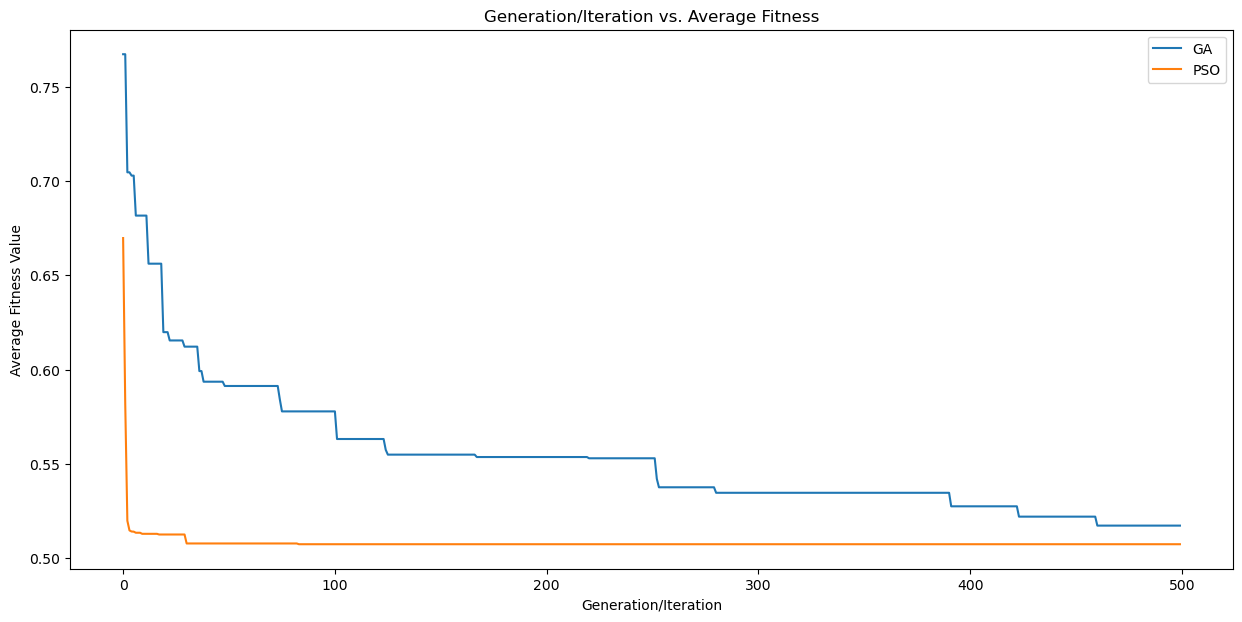

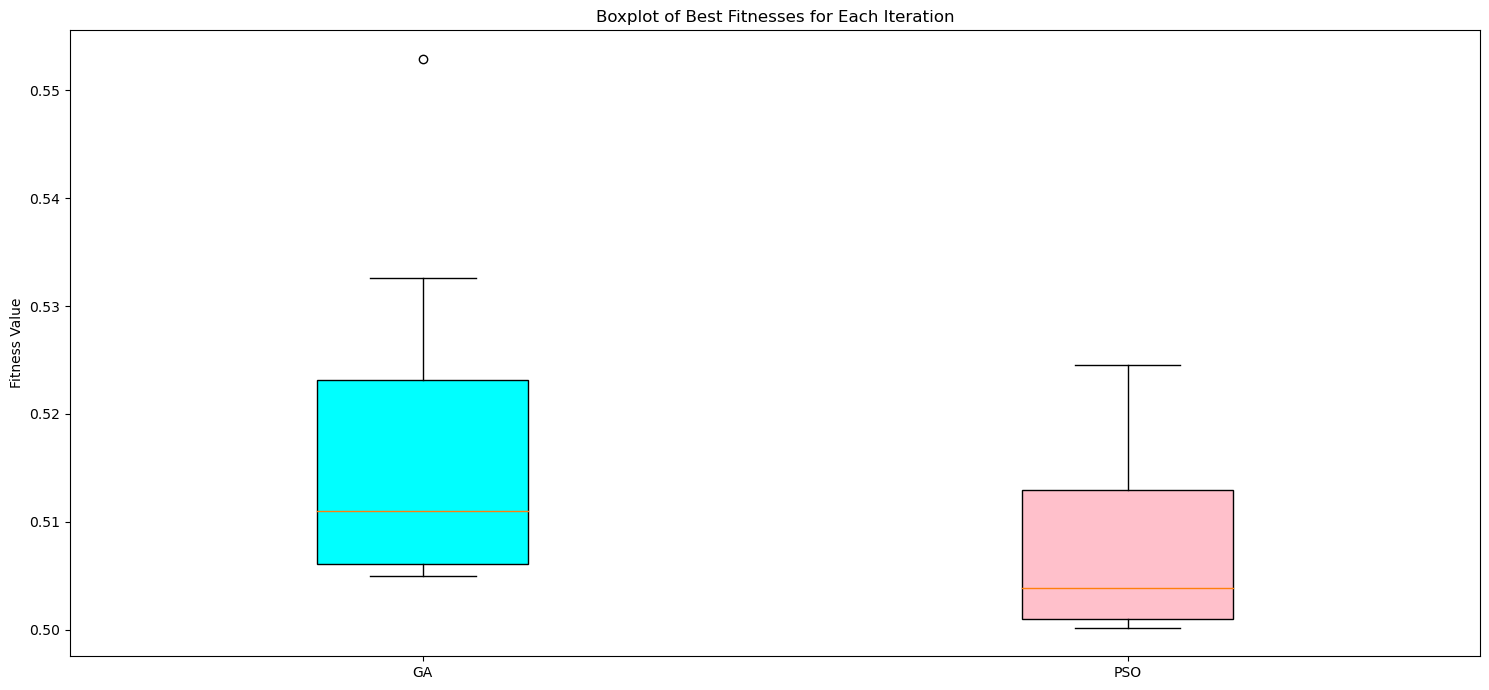

GA: Best solution is [0.1895974624282124, 0.1790875586819054, 0.10099724410394251] with fitness  0.5049862205197125 Found at run 8 and generation  102
PSO: Best solution is [0.5185994315718274, 0.18685311687579206, 0.10003250846009873] with fitness 0.5001625423004936 Found at run 7 and iteration 21


In [14]:
2# Setting the algorithm parameters
NUM_RUNS = 10

IND_LIMITS = [(0, 1), (0, 1),(0,1)]
IND_SIZE = 3

pop_size = 100
num_particles = 100

gen_max = 500
num_iterations = 500
# Running the algorithms and plotting
run_algorithms_and_plot(NUM_RUNS, IND_LIMITS, IND_SIZE, pop_size, gen_max, num_particles, num_iterations)

In [15]:
df.head()

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,...,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,behaviour,Type,rate_of_energy_consumption,cumulative_energy_consumption,energy_consumption,risk_score
0,1,0.100000,79,79,600.000000,5,0,79.255,1.255,48,...,100,0,79,4,No attack,normal,0.0,0.0,0.0,15.333692
1,2,0.100963,78,78,599.979723,5,800,79.255,1.255,48,...,100,0,79,4,No attack,normal,0.0,0.0,0.0,15.333692
2,2,0.100963,76,76,599.979722,5,800,79.255,1.255,48,...,100,0,79,4,No attack,normal,0.0,0.0,0.0,15.333692
3,2,0.100964,75,75,599.979722,5,800,79.255,1.255,48,...,100,0,79,4,No attack,normal,0.0,0.0,0.0,15.333692
4,2,0.100964,118,118,599.979722,5,800,79.255,1.255,48,...,100,0,79,4,No attack,normal,0.0,0.0,0.0,15.333692


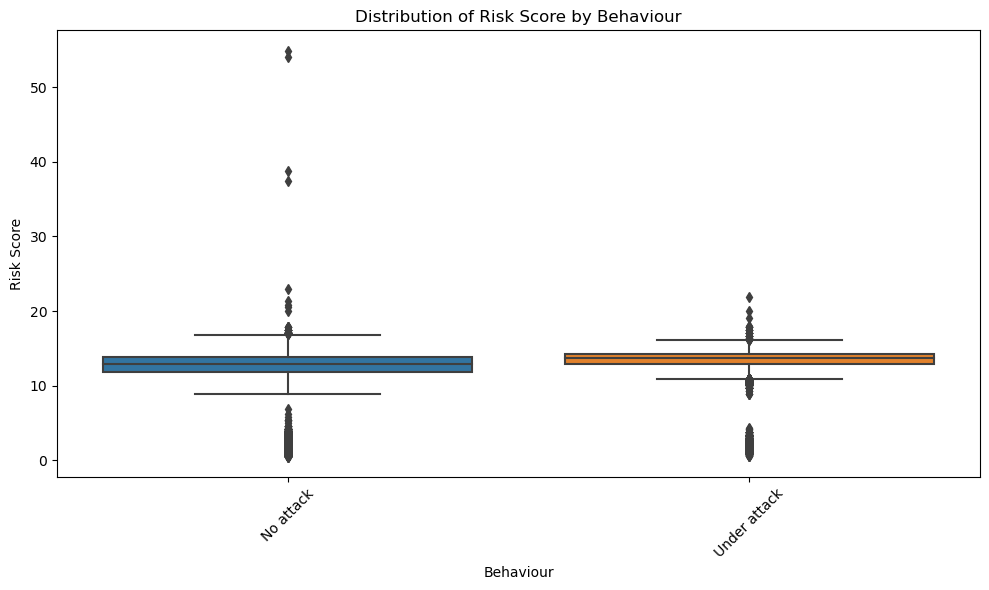

In [17]:

plt.figure(figsize=(10, 6))  
sns.boxplot(x='behaviour', y='risk_score', data=df)


plt.xlabel('Behaviour')
plt.ylabel('Risk Score')
plt.title('Distribution of Risk Score by Behaviour')
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()


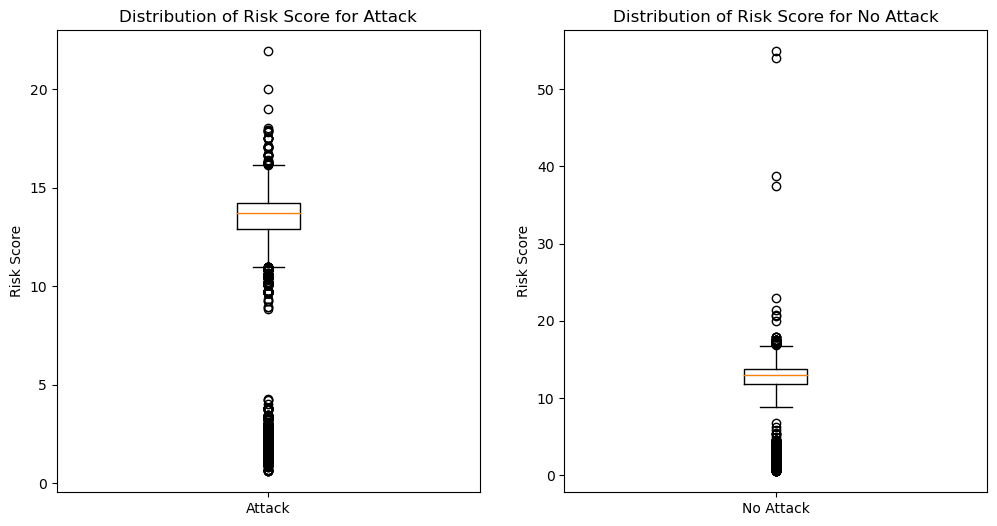

In [21]:



attack_df = df[df['behaviour'] == 'Under attack']
no_attack_df = df[df['behaviour'] == 'No attack']


fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].boxplot(attack_df['risk_score'])
axes[0].set_title('Distribution of Risk Score for Attack')
axes[0].set_ylabel('Risk Score')
axes[0].set_xticklabels(['Attack'])


axes[1].boxplot(no_attack_df['risk_score'])
axes[1].set_title('Distribution of Risk Score for No Attack')
axes[1].set_ylabel('Risk Score')
axes[1].set_xticklabels(['No Attack'])

plt.show()


In [23]:
df_under_attack = df[df['behaviour'] == 'Under attack']
df_under_attack

,Event,Time,S_Node,Node_id,Rest_Energy,Trace_Level,Mac_Type_Pckt,Source_IP_Port,Des_IP_Port,Packet_Size,...,Dest_Node_Num,Dest_Seq_Num,Src_Node_ID,Src_Seq_Num,behaviour,Type,rate_of_energy_consumption,cumulative_energy_consumption,energy_consumption,risk_score
7,2,0.100964,74,74,599.979722,5,800,79.255,1.255,48,...,100,0,79,4,Under attack,Blackhole,0.000000,0.000000,0.000000,15.333692
18,2,0.101384,43,43,599.979638,5,800,0.255,1.255,48,...,121,0,0,4,Under attack,Forwarding,0.000000,0.000000,0.000000,15.333692
49,1,0.102971,74,74,599.979326,5,800,74.255,1.255,106,...,100,0,79,4,Under attack,Blackhole,0.197340,0.000396,0.000396,14.986039
75,2,0.103839,43,43,599.979068,5,800,3.255,1.255,48,...,121,0,0,4,Under attack,Forwarding,0.232207,0.000570,0.000570,14.996152
85,2,0.103844,33,33,599.978982,5,800,74.255,1.255,48,...,100,0,79,4,Under attack,Blackhole,0.000000,0.000000,0.000000,14.928802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312101,4,656.526536,140,140,465.332078,5,800,140.255,1.255,48,...,100,16,140,68,Under attack,Blackhole,0.205346,134.644127,0.140273,15.393251
312102,4,657.209643,140,140,465.191806,5,800,140.255,1.255,48,...,100,16,140,72,Under attack,Blackhole,0.205344,134.784399,0.140272,15.393251
312103,4,657.891729,140,140,465.051737,5,800,140.255,1.255,48,...,100,16,140,76,Under attack,Blackhole,0.205354,134.924468,0.140069,15.393254
312104,4,658.574656,140,140,464.911501,5,800,140.255,1.255,48,...,100,16,140,80,Under attack,Blackhole,0.205346,135.064704,0.140236,15.393251


In [24]:
df_under_attack['risk_score'].min()

0.6168360308104938

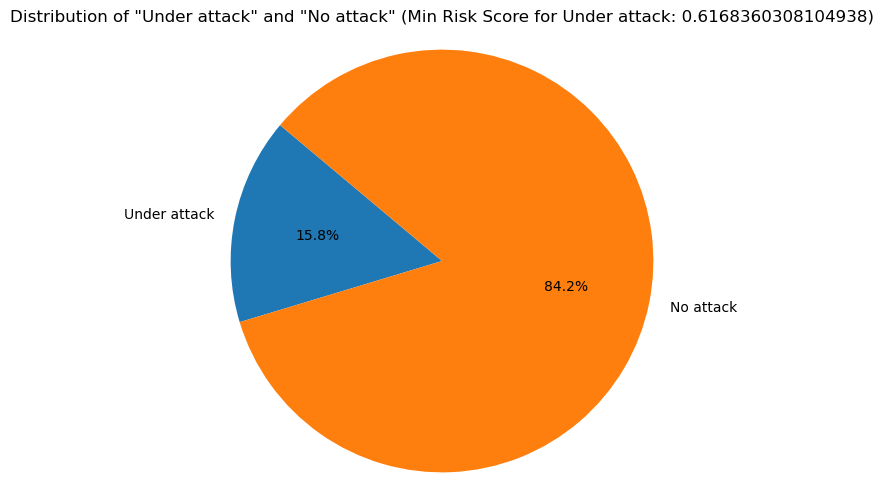

In [27]:

min_risk_score_under_attack = df_under_attack['risk_score'].min()


plt.figure(figsize=(6, 6))
plt.pie([len(df_under_attack), len(df) - len(df_under_attack)], labels=["Under attack", "No attack"], autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of "Under attack" and "No attack" (Min Risk Score for Under attack: {min_risk_score_under_attack})')
plt.axis('equal')  
plt.show()


C:\Users\linam\AppData\Local\Temp\ipykernel_31304\886545197.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100


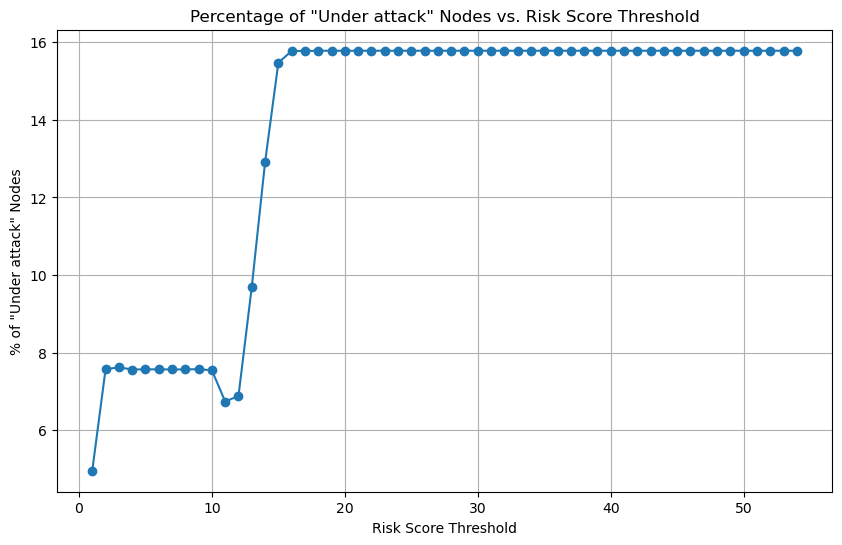

In [28]:

thresholds = range(int(df['risk_score'].min()), int(df['risk_score'].max()) + 1)


threshold_values = []
under_attack_percentages = []


for threshold in thresholds:
    filtered_data = df[df['risk_score'] <= threshold]
    
    
    under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100
    
    
    threshold_values.append(threshold)
    under_attack_percentages.append(under_attack_percentage)


plt.figure(figsize=(10, 6))
plt.plot(threshold_values, under_attack_percentages, marker='o', linestyle='-')
plt.xlabel('Risk Score Threshold')
plt.ylabel('% of "Under attack" Nodes')
plt.title('Percentage of "Under attack" Nodes vs. Risk Score Threshold')
plt.grid(True)
plt.show()


In [29]:
# Define a range of risk score thresholds to test
thresholds = range(int(df['risk_score'].min()), int(df['risk_score'].max()) + 1)

# Initialize lists to store threshold values and corresponding percentages of "Under attack"
threshold_values = []
under_attack_percentages = []

# Iterate through the thresholds
for threshold in thresholds:
    # Filter the data for nodes with risk scores less than or equal to the threshold
    filtered_data = df[df['risk_score'] <= threshold]
    
    under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100
    
    # Append the threshold and percentage to the respective lists
    threshold_values.append(threshold)
    under_attack_percentages.append(under_attack_percentage)

# Print the threshold values and corresponding percentages
for threshold, percentage in zip(threshold_values, under_attack_percentages):
    print(f"Threshold: {threshold}, % of 'Under attack' Nodes: {percentage:.2f}%")


C:\Users\linam\AppData\Local\Temp\ipykernel_31304\3583764850.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100


Threshold: 0, % of 'Under attack' Nodes: nan%
Threshold: 1, % of 'Under attack' Nodes: 4.96%
Threshold: 2, % of 'Under attack' Nodes: 7.57%
Threshold: 3, % of 'Under attack' Nodes: 7.62%
Threshold: 4, % of 'Under attack' Nodes: 7.57%
Threshold: 5, % of 'Under attack' Nodes: 7.57%
Threshold: 6, % of 'Under attack' Nodes: 7.57%
Threshold: 7, % of 'Under attack' Nodes: 7.57%
Threshold: 8, % of 'Under attack' Nodes: 7.57%
Threshold: 9, % of 'Under attack' Nodes: 7.57%
Threshold: 10, % of 'Under attack' Nodes: 7.54%
Threshold: 11, % of 'Under attack' Nodes: 6.74%
Threshold: 12, % of 'Under attack' Nodes: 6.88%
Threshold: 13, % of 'Under attack' Nodes: 9.69%
Threshold: 14, % of 'Under attack' Nodes: 12.91%
Threshold: 15, % of 'Under attack' Nodes: 15.47%
Threshold: 16, % of 'Under attack' Nodes: 15.77%
Threshold: 17, % of 'Under attack' Nodes: 15.78%
Threshold: 18, % of 'Under attack' Nodes: 15.78%
Threshold: 19, % of 'Under attack' Nodes: 15.78%
Threshold: 20, % of 'Under attack' Nodes: 15.

C:\Users\linam\AppData\Local\Temp\ipykernel_31304\1400546780.py:17: RuntimeWarning: invalid value encountered in longlong_scalars
  under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100


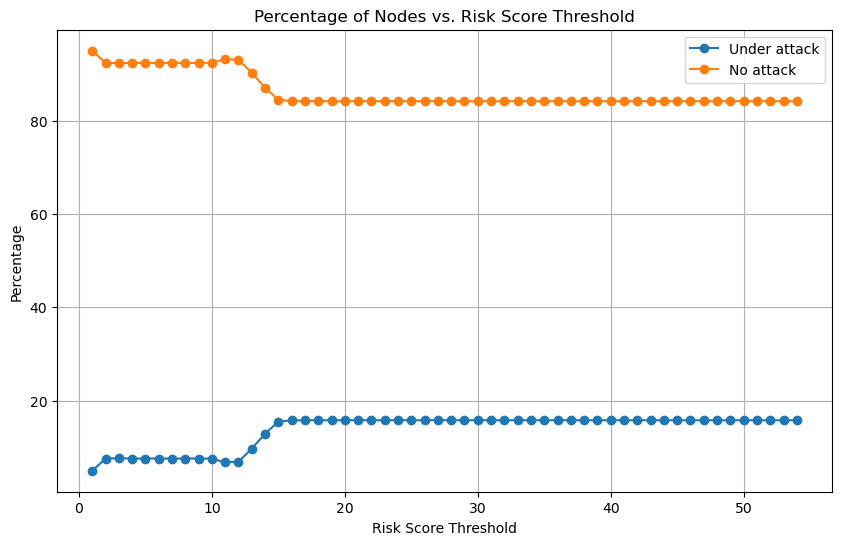

In [35]:
thresholds = range(int(df['risk_score'].min()), int(df['risk_score'].max()) + 1)
threshold_values = []
under_attack_percentages = []
no_attack_percentages = []
for threshold in thresholds:
    filtered_data = df[df['risk_score'] <= threshold]
    
    under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100
    
    no_attack_percentage = 100 - under_attack_percentage
    
    threshold_values.append(threshold)
    under_attack_percentages.append(under_attack_percentage)
    no_attack_percentages.append(no_attack_percentage)
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, under_attack_percentages, marker='o', linestyle='-', label='Under attack')
plt.plot(threshold_values, no_attack_percentages, marker='o', linestyle='-', label='No attack')
plt.xlabel('Risk Score Threshold')
plt.ylabel('Percentage')
plt.title('Percentage of Nodes vs. Risk Score Threshold')
plt.legend()
plt.grid(True)
plt.show()


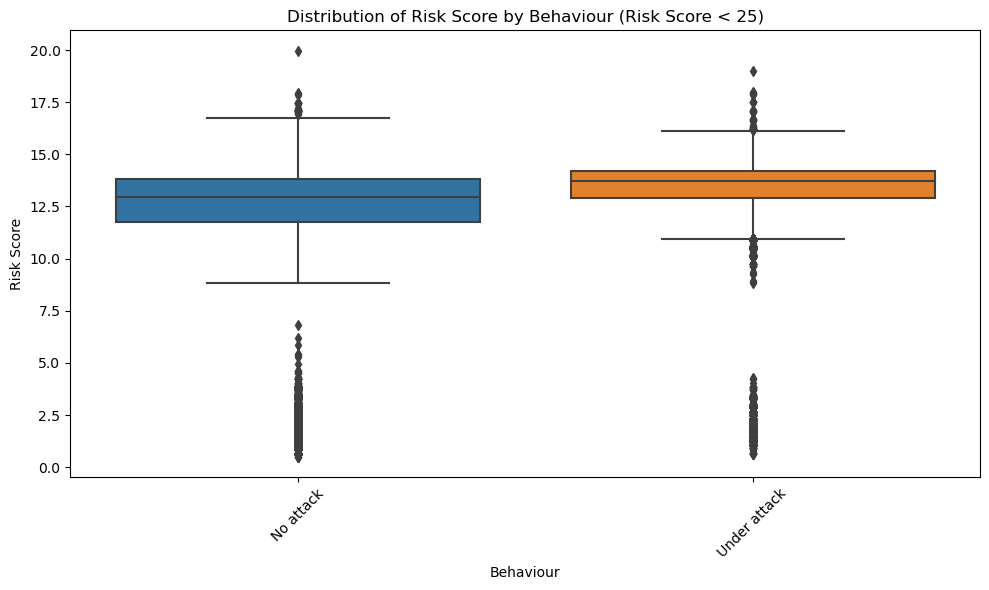

In [37]:
filtered_df = df[df['risk_score'] < 20]
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='behaviour', y='risk_score', data=filtered_df)
plt.xlabel('Behaviour')
plt.ylabel('Risk Score')
plt.title('Distribution of Risk Score by Behaviour (Risk Score < 20)')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


In [38]:
df['behaviour'].value_counts()

No attack       262851
Under attack     49255
Name: behaviour, dtype: int64

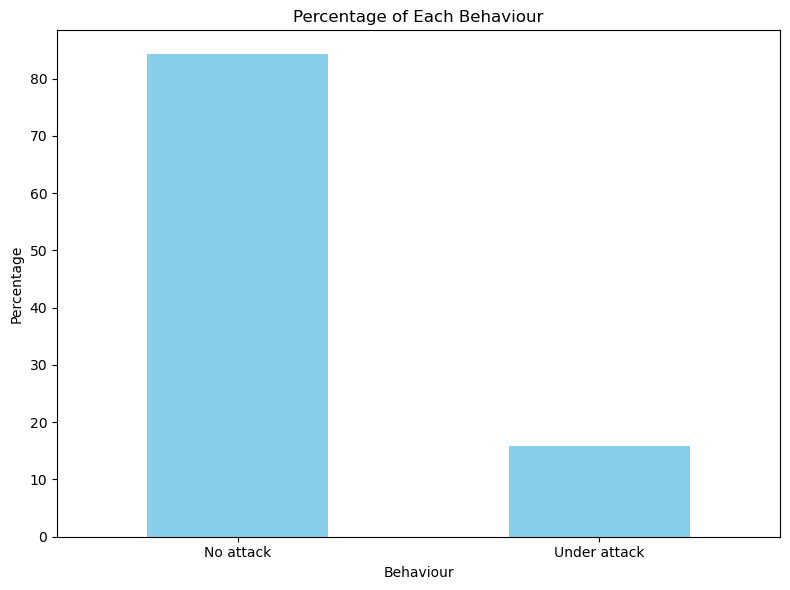

In [39]:
import matplotlib.pyplot as plt


behaviour_counts = df['behaviour'].value_counts()


percentages = (behaviour_counts / len(df)) * 100


plt.figure(figsize=(8, 6))
percentages.plot(kind='bar', color='skyblue')
plt.title('Percentage of Each Behaviour')
plt.xlabel('Behaviour')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()


C:\Users\linam\AppData\Local\Temp\ipykernel_31304\3987061090.py:14: RuntimeWarning: invalid value encountered in longlong_scalars
  under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100


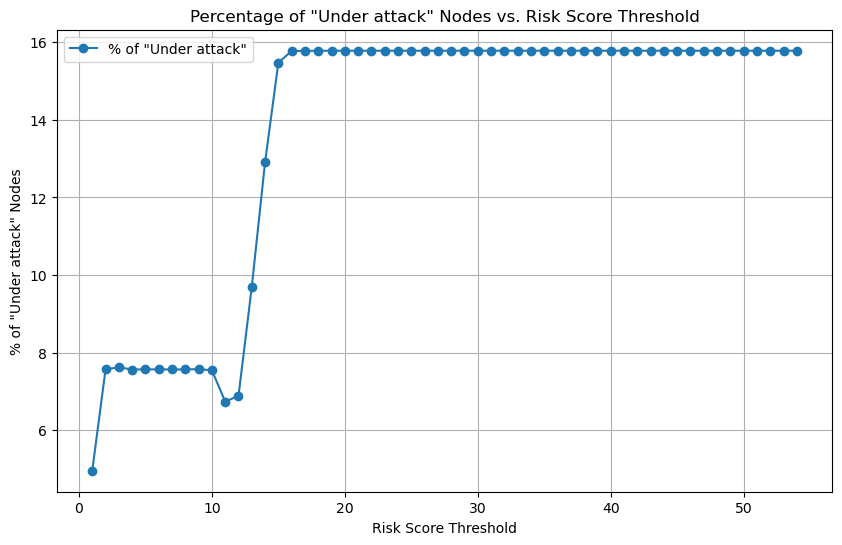

In [40]:


# Define a range of risk score thresholds to test (as integers)
thresholds = range(int(df['risk_score'].min()), int(df['risk_score'].max()) + 1)


threshold_values = []
under_attack_percentages = []


for threshold in thresholds:
    filtered_data = df[df['risk_score'] <= threshold]
    under_attack_percentage = (filtered_data['behaviour'] == 'Under attack').sum() / len(filtered_data) * 100
    
    threshold_values.append(threshold)
    under_attack_percentages.append(under_attack_percentage)

plt.figure(figsize=(10, 6))
plt.plot(threshold_values, under_attack_percentages, marker='o', linestyle='-', label='% of "Under attack"')
plt.xlabel('Risk Score Threshold')
plt.ylabel('% of "Under attack" Nodes')
plt.title('Percentage of "Under attack" Nodes vs. Risk Score Threshold')
plt.grid(True)
plt.legend()  # Add a legend to the plot
plt.show()


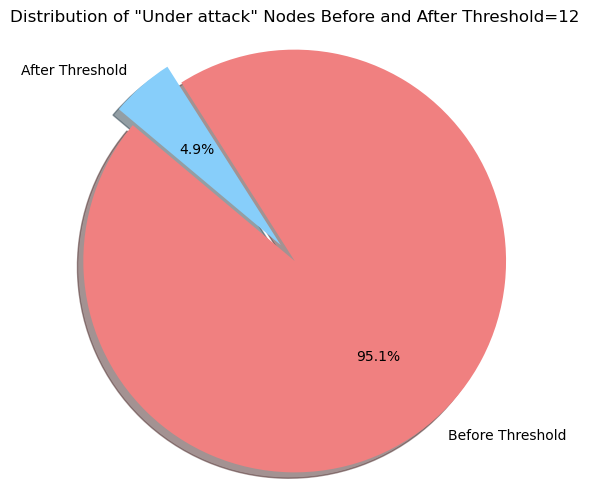

In [74]:
threshold = 12  

before_attack_count = (df[df['risk_score'] <= threshold]['behaviour'] == 'Under attack').sum()
after_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'Under attack').sum()


labels = ['Before Threshold', 'After Threshold']
sizes = [before_attack_count, after_attack_count]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of "Under attack" Nodes Before and After Threshold=12')
plt.axis('equal')  

plt.show()


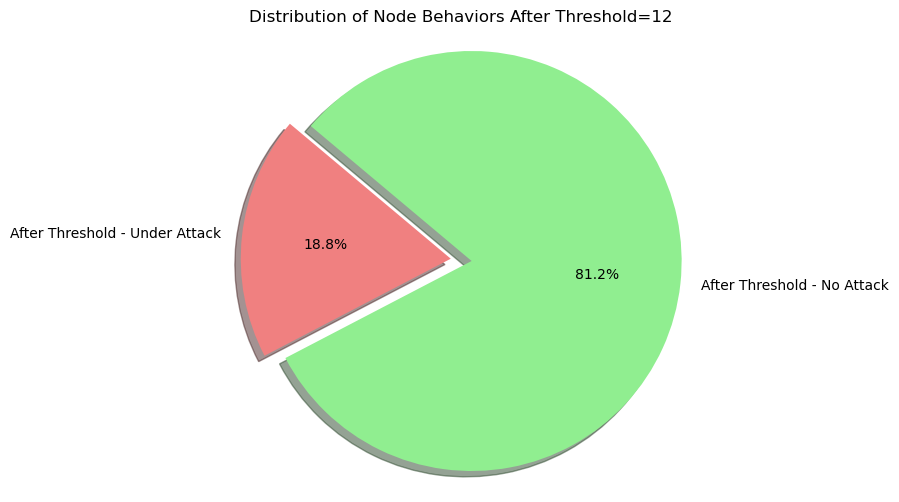

In [50]:
threshold = 12 
after_under_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'Under attack').sum()
after_no_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'No attack').sum()
labels = ['After Threshold - Under Attack', 'After Threshold - No Attack']
sizes = [after_under_attack_count, after_no_attack_count]
colors = ['lightcoral', 'lightgreen']
explode = (0.1, 0) 
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Node Behaviors After Threshold=12')
plt.axis('equal')  

plt.show()


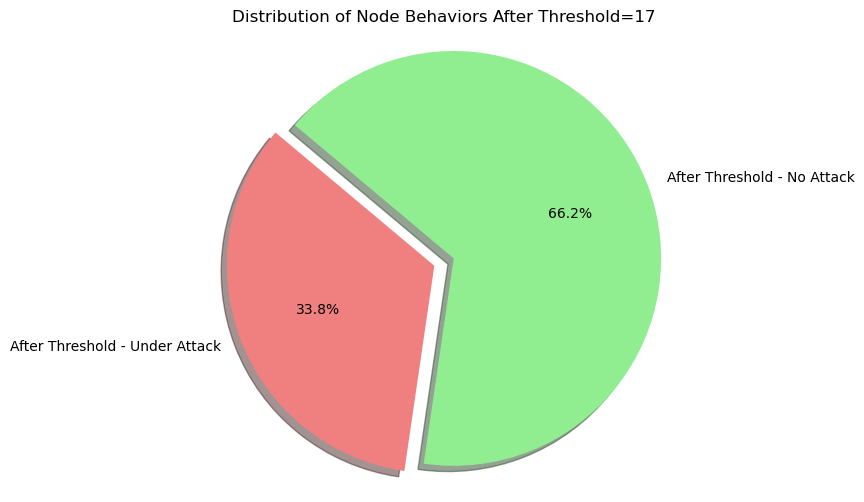

In [79]:

threshold = 17  
after_under_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'Under attack').sum()
after_no_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'No attack').sum()
labels = ['After Threshold - Under Attack', 'After Threshold - No Attack']
sizes = [after_under_attack_count, after_no_attack_count]
colors = ['lightcoral', 'lightgreen']
explode = (0.1, 0)  

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Node Behaviors After Threshold=17')
plt.axis('equal')  

plt.show()

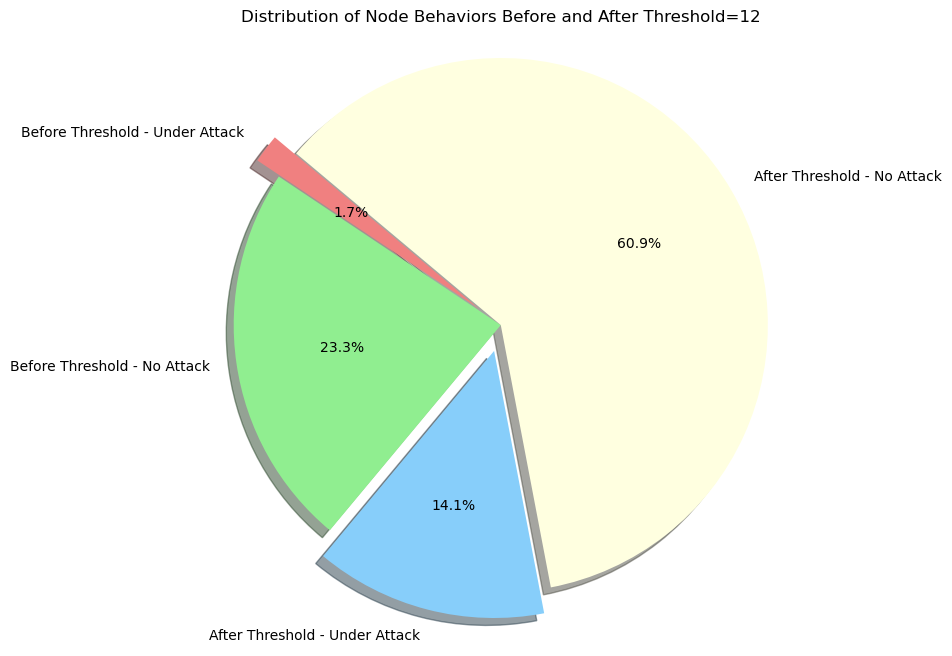

In [69]:
threshold = 12  

before_under_attack_count = (df[df['risk_score'] <= threshold]['behaviour'] == 'Under attack').sum()
before_no_attack_count = (df[df['risk_score'] <= threshold]['behaviour'] == 'No attack').sum()

after_under_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'Under attack').sum()
after_no_attack_count = (df[df['risk_score'] > threshold]['behaviour'] == 'No attack').sum()


labels = ['Before Threshold - Under Attack', 'Before Threshold - No Attack', 'After Threshold - Under Attack', 'After Threshold - No Attack']
sizes = [before_under_attack_count, before_no_attack_count, after_under_attack_count, after_no_attack_count]
colors = ['lightcoral', 'lightgreen', 'lightskyblue', 'lightyellow']
explode = (0.1, 0, 0.1, 0)  
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Node Behaviors Before and After Threshold=12')
plt.axis('equal')  

plt.show()
